In [1]:
import os
import sys

import pandas as pd
import numpy as np
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.integrate import odeint

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Initial Pandemic conditions

In [2]:
N = 8_000_000
days = 365
init_infections = 1000
init_recoveries = 0

### Math behind Pandemic

In [3]:
def diff(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def sir_model(simulation_length, population_size, init_infections, init_recoveries, 
              reproductive_number, recovery_time):
    daily_reproductive_number = reproductive_number/recovery_time
    daily_recovery_number = 1.0/recovery_time 
    
    t = [i for i in range(1,simulation_length+1)]
    
    I0 = init_infections
    S0 = population_size - I0
    R0 = init_recoveries
    
    y0 = S0, I0, R0
    
    ret = odeint(diff, y0, t, args=(population_size, daily_reproductive_number, daily_recovery_number))
    S, I, R = ret.T
    return S, I, R

### Illustration of how a pandemic spreads

In [4]:
# N = 1000
# days = 100
# init_infections = 10
# init_recoveries = 0

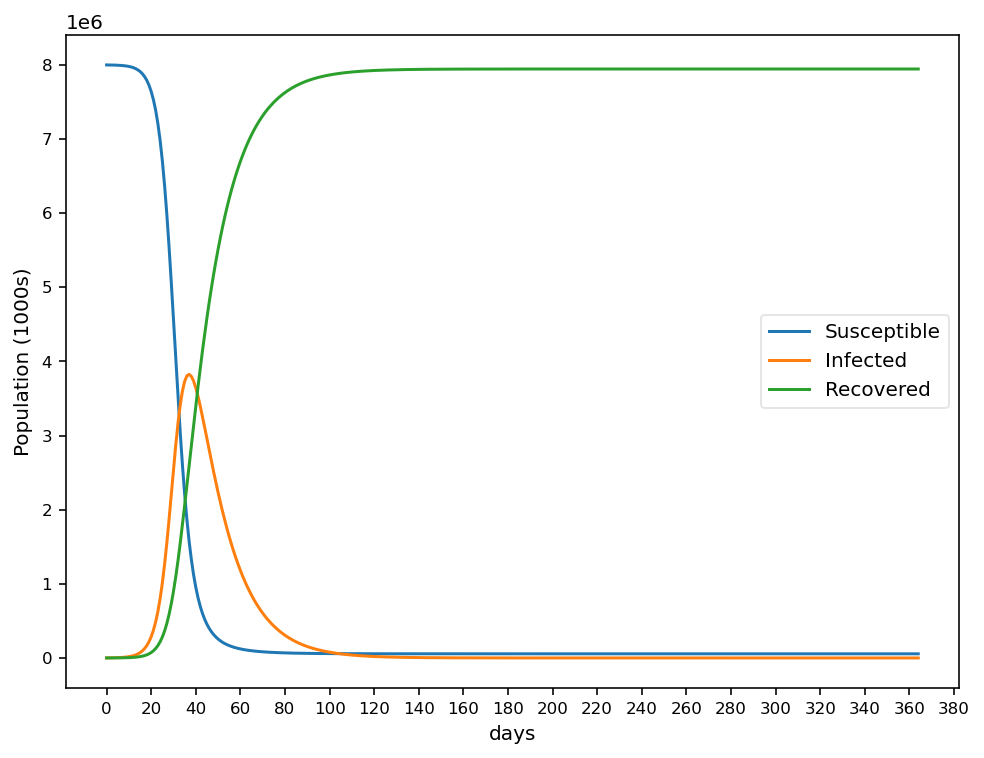

In [5]:
R0 = 5.0
recovery_time = 14

S, I, R = sir_model(days, N, init_infections, init_recoveries, R0, recovery_time)

fig = plt.figure(figsize= (8,6))

ax = fig.add_subplot(1,1,1)
ax.plot(S,label='Susceptible')
ax.plot(I,label='Infected')
ax.plot(R,label='Recovered')
ax.set_xlabel('days')
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel('Population (1000s)')
ax.tick_params(axis='both', labelsize='small')

legend = ax.legend()
legend.get_frame().set_alpha(0.5)

max_infected = np.max(I)/N * 100
max_infected_in_days = np.argmax(I)

# scenario = 'Pandemic just spreading and nothing is being done, R0={}'.format(R0)
# pop_affected = '{}% population gets affected by {} days'.format(round(max_infected,2), max_infected_in_days)

# ax.set_title('{}\n{}'.format(scenario, pop_affected), fontsize=10)

plt.show()

### Impact of R0 on pandemic spread

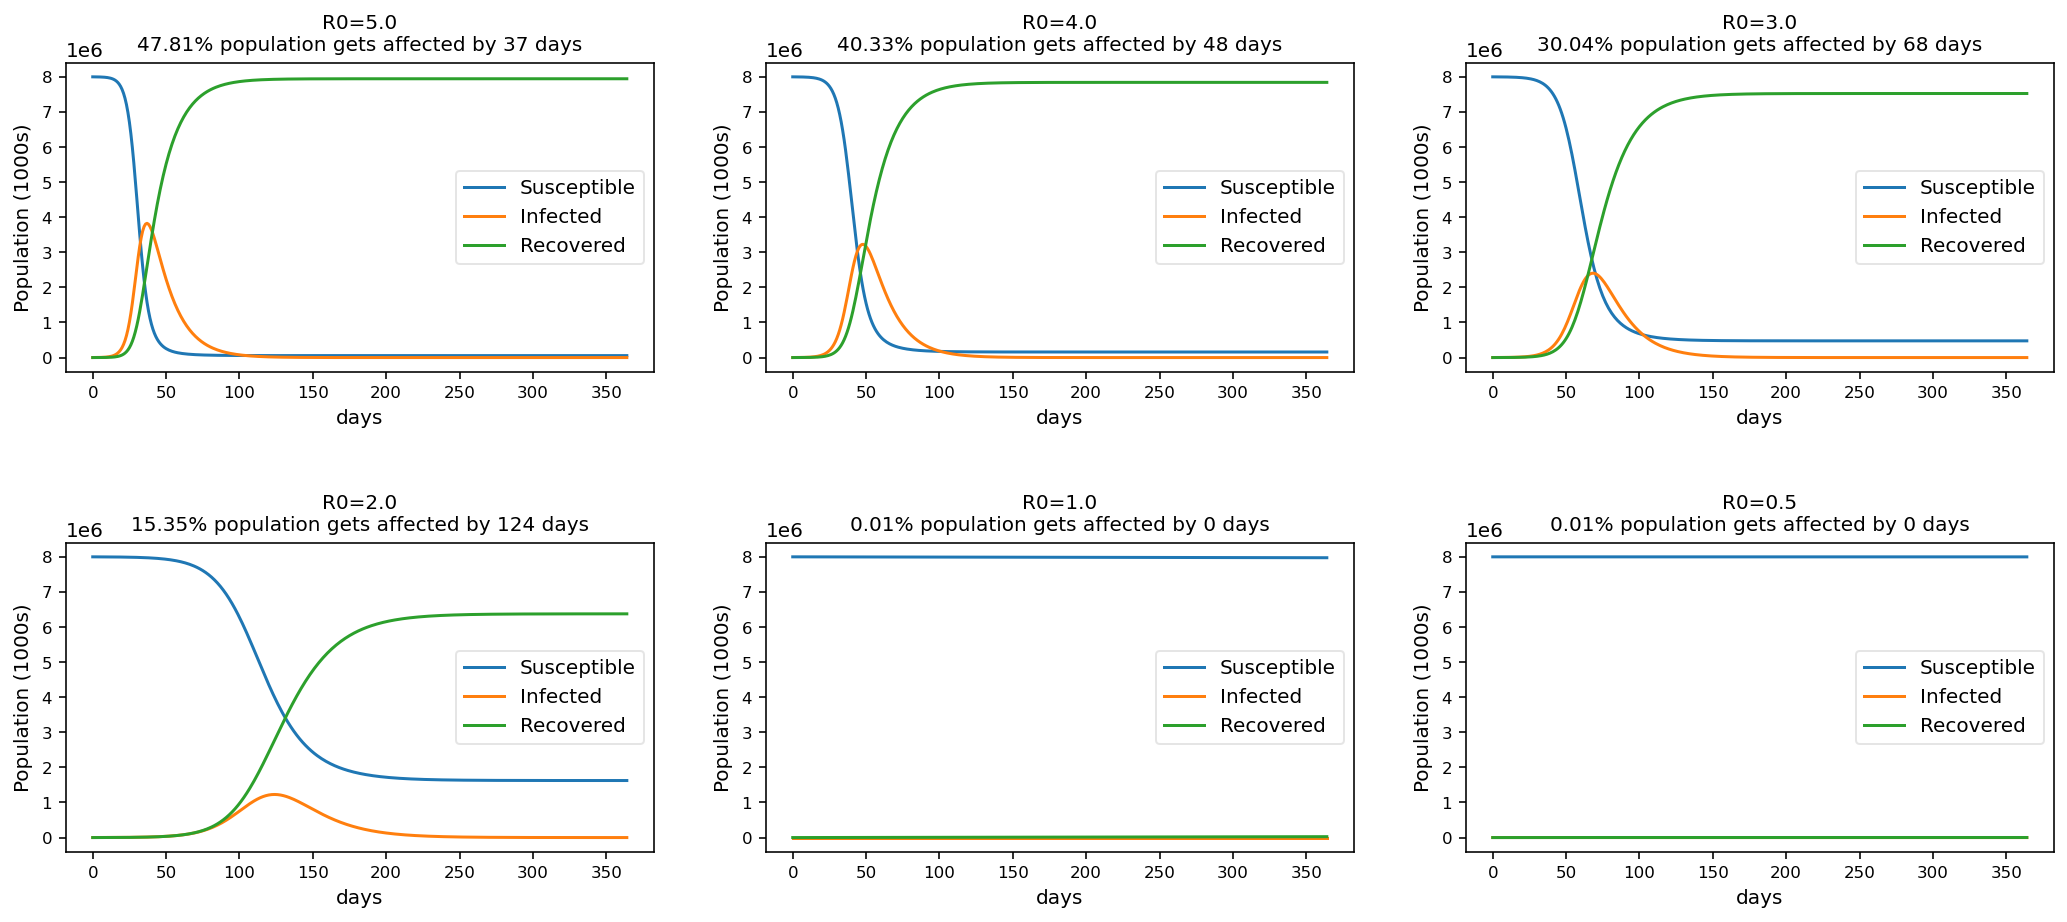

In [6]:
R0_values = [5.0,4.0,3.0,2.0,1.0,0.5]
recovery_time = 14 

fig = plt.figure(figsize= (15,10))
for i in range(0,len(R0_values)):
    S, I, R = sir_model(days, N, init_infections, init_recoveries, R0_values[i], recovery_time)
    
    ax = fig.add_subplot(3,3,i+1)
    ax.plot(S,label='Susceptible')
    ax.plot(I,label='Infected')
    ax.plot(R,label='Recovered')
    ax.set_xlabel('days')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_ylabel('Population (1000s)')
    ax.tick_params(axis='both', labelsize='small')
    
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    maxI = np.max(I)/N * 100
    maxIdays = np.argmax(I)
    scenario = 'R0={}'.format(R0_values[i])
    pop_affected = '{}% population gets affected by {} days'.format(round(maxI,2), maxIdays)
    ax.set_title('{}\n{}'.format(scenario, pop_affected), fontsize=10)
    
plt.tight_layout(pad=3.0) 

### Government passes handwashing guidelines

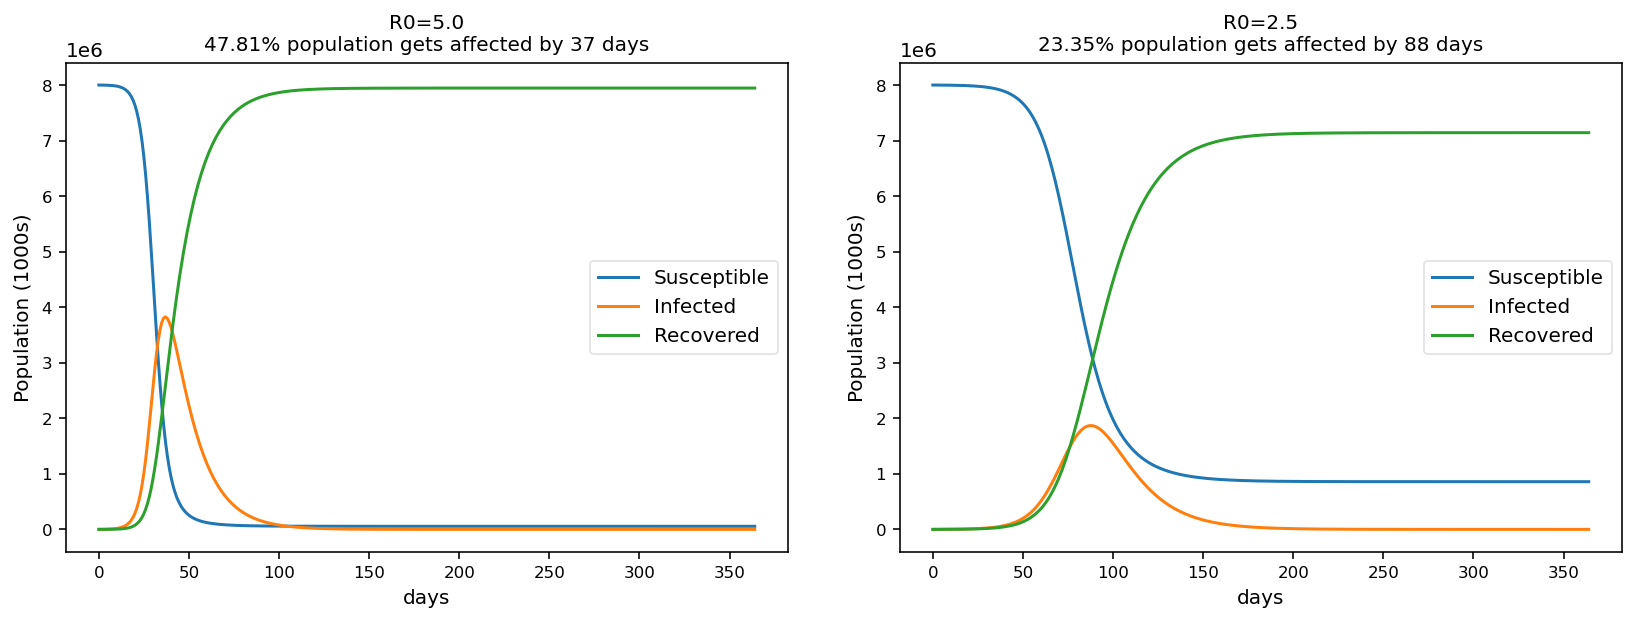

In [7]:
R0_values = [5.0,2.5]
recovery_time = 14 

fig = plt.figure(figsize= (12,5))
for i in range(0,len(R0_values)):
    S, I, R = sir_model(days, N, init_infections, init_recoveries, R0_values[i], recovery_time)
    
    ax = fig.add_subplot(1,2,i+1)
    ax.plot(S,label='Susceptible')
    ax.plot(I,label='Infected')
    ax.plot(R,label='Recovered')
    ax.set_xlabel('days')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_ylabel('Population (1000s)')
    ax.tick_params(axis='both', labelsize='small')
    
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    maxI = np.max(I)/N * 100
    maxIdays = np.argmax(I)
    scenario = 'R0={}'.format(R0_values[i])
    pop_affected = '{}% population gets affected by {} days'.format(round(maxI,2), maxIdays)
    ax.set_title('{}\n{}'.format(scenario, pop_affected), fontsize=10)
    
plt.tight_layout(pad=3.0) 

### Government implements a lockdown

In [8]:
def f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end):
    if t >= lockdown_start and t <= lockdown_end:
        return lockdown_beta
    else:
        return beta

def diff_1(y, t, N, beta, gamma, lockdown_beta, lockdown_start, lockdown_end):
    S, I, R = y
    dSdt = -f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end) * S * I / N
    dIdt = f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def sir_model_1(simulation_length, population_size, init_infections, init_recoveries, 
              reproductive_number, recovery_time, lockdown_reproductive_number, lockdown_start, lockdown_end):
    daily_reproductive_number = reproductive_number/recovery_time
    daily_recovery_number = 1.0/recovery_time 
    
    lockdown_daily_reproductive_number = lockdown_reproductive_number/recovery_time
    
    t = [i for i in range(1,simulation_length+1)]
    
    I0 = init_infections
    S0 = population_size - I0
    R0 = init_recoveries
    
    y0 = S0, I0, R0
    
    ret = odeint(diff_1, y0, t, args=(population_size, daily_reproductive_number, daily_recovery_number, 
                                            lockdown_daily_reproductive_number, lockdown_start, lockdown_end))
    S, I, R = ret.T
    return S, I, R

### Illustration of a 30-day lockdown 2-weeks after outbreak

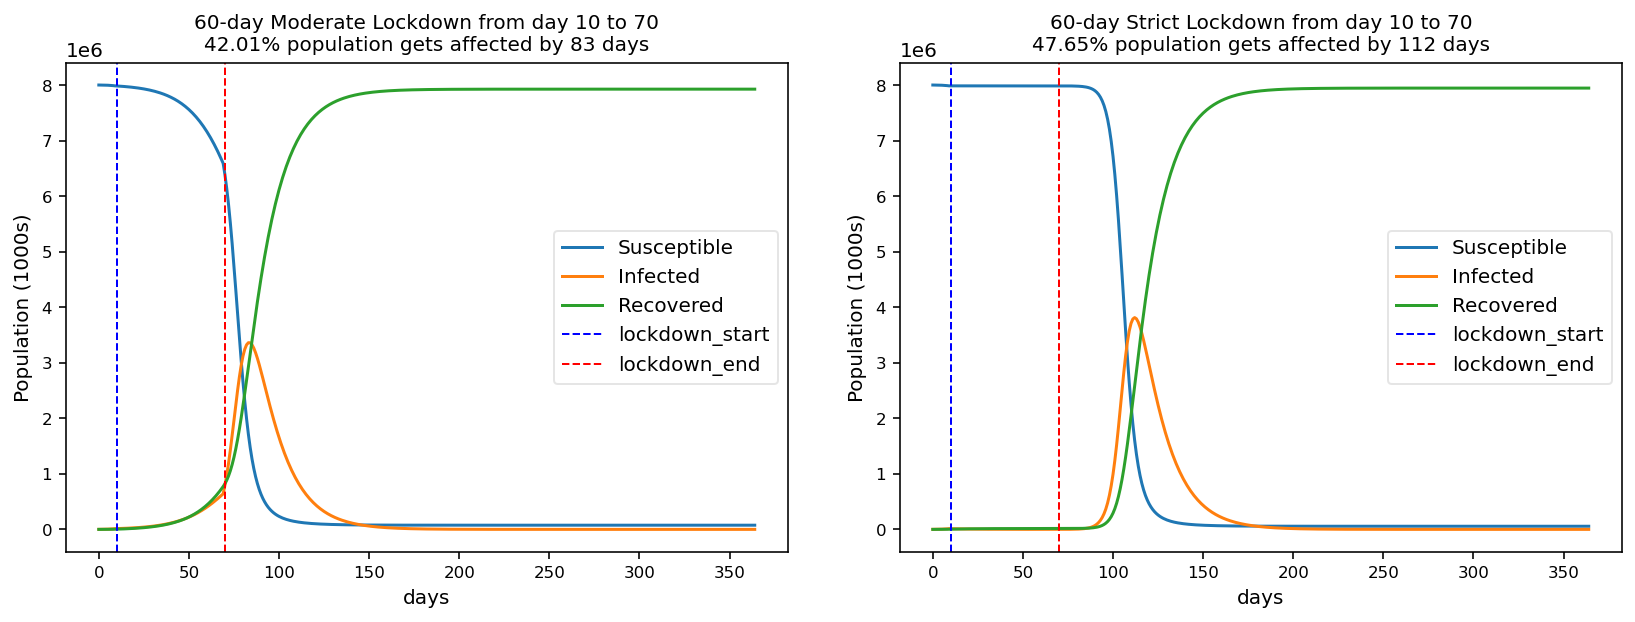

In [9]:
R0 = 5.0
recovery_time = 14.0 

lockdowns = [
    {'start':10, 'length':60, 'type':'Moderate', 'R0':2.0}, 
    {'start':10, 'length':60, 'type':'Strict', 'R0':0.0}
]

fig = plt.figure(figsize= (12,5))
for i in range(0,len(lockdowns)):
    lockdown_R0 = lockdowns[i].get('R0')
    lockdown_start = lockdowns[i].get('start')
    lockdown_length = lockdowns[i].get('length')
    lockdown_end = lockdown_start + lockdown_length
    lockdown_type = lockdowns[i].get('type')
 
    S, I, R = sir_model_1(days, N, init_infections, init_recoveries, R0, recovery_time, 
                                 lockdown_R0, lockdown_start, lockdown_end)
    
    ax = fig.add_subplot(1,2,i+1)
    ax.plot(S,label='Susceptible')
    ax.plot(I,label='Infected')
    ax.plot(R,label='Recovered')
    ax.set_xlabel('days')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_ylabel('Population (1000s)')
    ax.tick_params(axis='both', labelsize='small')
    ax.axvline(x=lockdown_start, linewidth=1, ls = "--",color='b', label="lockdown_start")
    ax.axvline(x=lockdown_end, linewidth=1, ls = "--",color='r', label="lockdown_end")
    ax.legend(["lockdown start","lockdown end"])
    
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    maxI = np.max(I)/N * 100
    maxIdays = np.argmax(I)
    scenario = '{}-day {} Lockdown from day {} to {}'.format(lockdown_length, lockdown_type, lockdown_start, lockdown_end)
    pop_affected = '{}% population gets affected by {} days'.format(round(maxI,2), maxIdays)
    ax.set_title('{}\n{}'.format(scenario, pop_affected), fontsize=10)
    
plt.tight_layout(pad=3.0) 

### Simulating more lockdown options

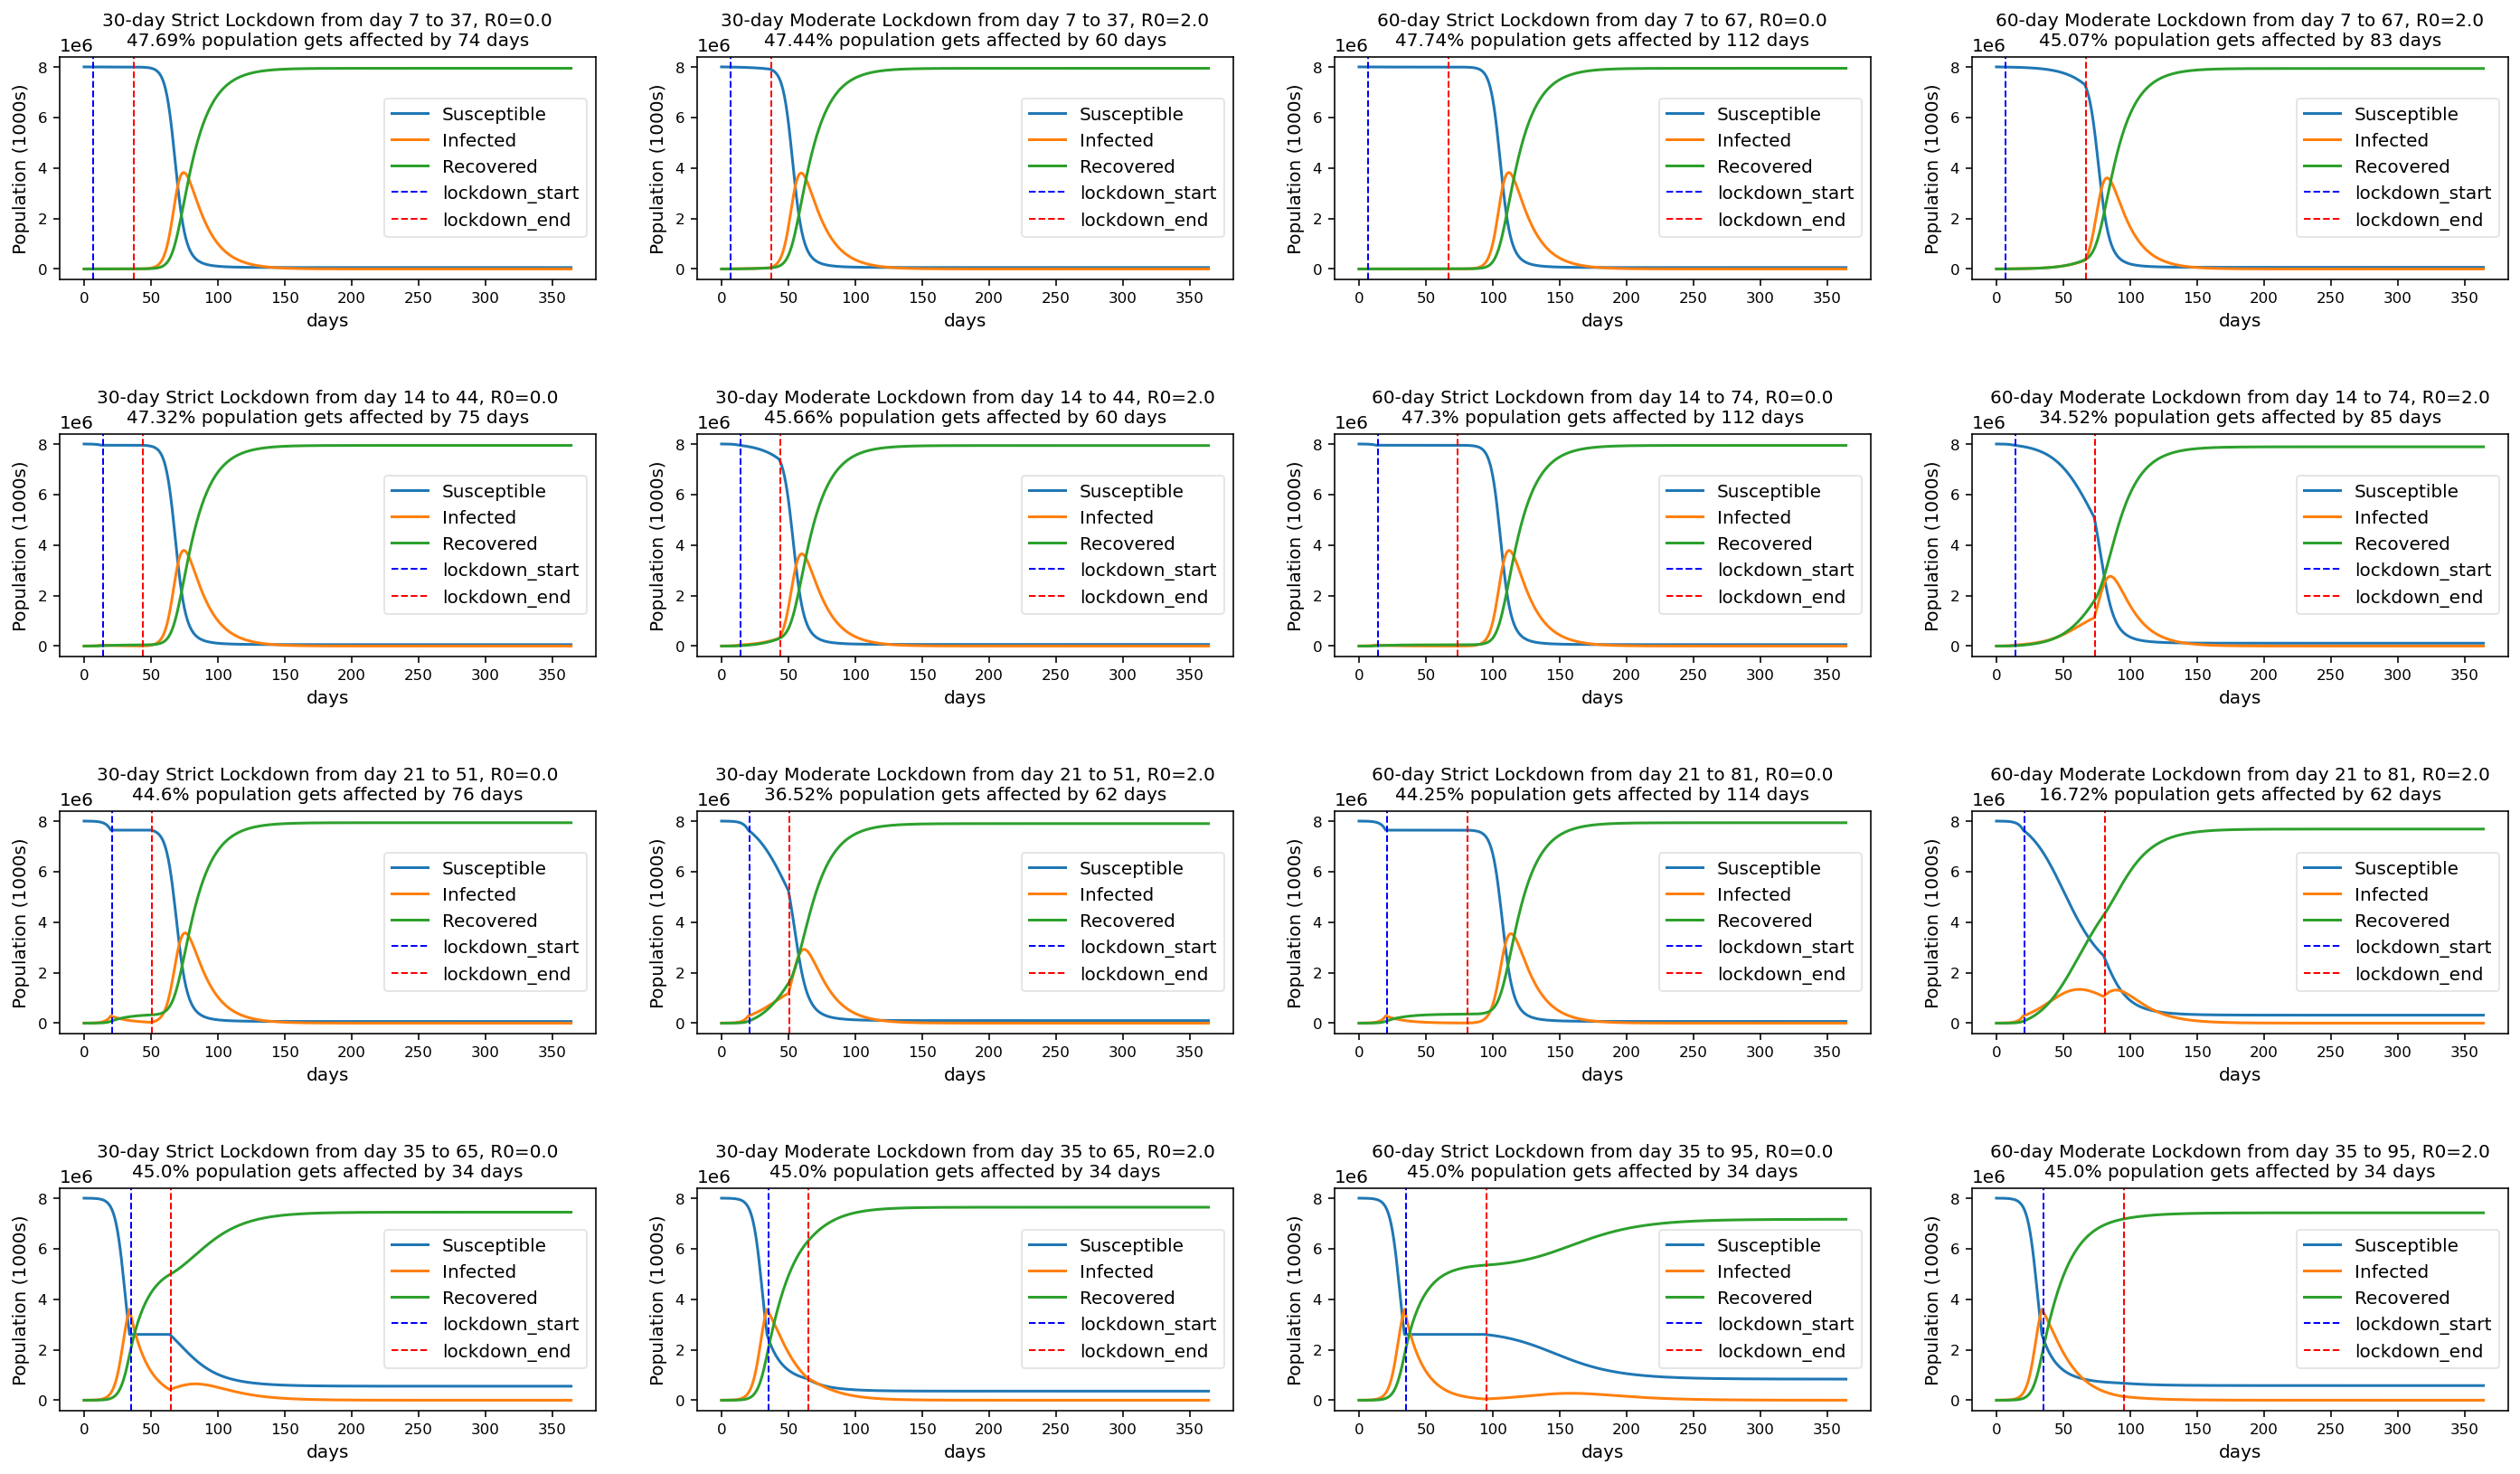

In [10]:
R0 = 5.0
recovery_time = 14.0

# lockdowns = [
#     {'start':21, 'length':30, 'type':'Strict', 'R0':0.0},
#     {'start':14, 'length':30, 'type':'Strict', 'R0':0.0},
#     {'start':7, 'length':30, 'type':'Strict', 'R0':0.0},
    
#     {'start':21, 'length':60, 'type':'Strict', 'R0':0.0},
#     {'start':14, 'length':60, 'type':'Strict', 'R0':0.0},
#     {'start':7, 'length':60, 'type':'Strict', 'R0':0.0}
# ]

lockdowns = [
    {'start':7, 'length':30, 'type':'Strict', 'R0':0.0},
    {'start':7, 'length':30, 'type':'Moderate', 'R0':2.0},
    {'start':7, 'length':60, 'type':'Strict', 'R0':0.0},
    {'start':7, 'length':60, 'type':'Moderate', 'R0':2.0},
    
    {'start':14, 'length':30, 'type':'Strict', 'R0':0.0},
    {'start':14, 'length':30, 'type':'Moderate', 'R0':2.0},
    {'start':14, 'length':60, 'type':'Strict', 'R0':0.0},
    {'start':14, 'length':60, 'type':'Moderate', 'R0':2.0},
    
    {'start':21, 'length':30, 'type':'Strict', 'R0':0.0},
    {'start':21, 'length':30, 'type':'Moderate', 'R0':2.0},
    {'start':21, 'length':60, 'type':'Strict', 'R0':0.0},
    {'start':21, 'length':60, 'type':'Moderate', 'R0':2.0},
    
    {'start':35, 'length':30, 'type':'Strict', 'R0':0.0},
    {'start':35, 'length':30, 'type':'Moderate', 'R0':2.0},
    {'start':35, 'length':60, 'type':'Strict', 'R0':0.0},
    {'start':35, 'length':60, 'type':'Moderate', 'R0':2.0}
]

fig = plt.figure(figsize= (20,12))
for i in range(0,len(lockdowns)):
    lockdown_R0 = lockdowns[i].get('R0')
    lockdown_start = lockdowns[i].get('start')
    lockdown_length = lockdowns[i].get('length')
    lockdown_end = lockdown_start + lockdown_length
    lockdown_type = lockdowns[i].get('type')
 
    S, I, R = sir_model_1(days, N, init_infections, init_recoveries, R0, recovery_time, 
                                 lockdown_R0, lockdown_start, lockdown_end)
    
#     ax = fig.add_subplot(3,3,i+1)
    ax = fig.add_subplot(4,4,i+1)
    ax.plot(S,label='Susceptible')
    ax.plot(I,label='Infected')
    ax.plot(R,label='Recovered')
    ax.set_xlabel('days')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_ylabel('Population (1000s)')
    ax.tick_params(axis='both', labelsize='small')
    ax.axvline(x=lockdown_start, linewidth=1, ls = "--",color='b', label="lockdown_start")
    ax.axvline(x=lockdown_end, linewidth=1, ls = "--",color='r', label="lockdown_end")
    ax.legend(["lockdown start","lockdown end"])
    
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    maxI = np.max(I)/N * 100
    maxIdays = np.argmax(I)
    scenario = '{}-day {} Lockdown from day {} to {}, R0={}'.format(lockdown_length, lockdown_type, lockdown_start, lockdown_end, lockdown_R0)
    pop_affected = '{}% population gets affected by {} days'.format(round(maxI,2), maxIdays)
    ax.set_title('{}\n{}'.format(scenario, pop_affected), fontsize=10)
    
plt.tight_layout(pad=3.0) 

### Improved recovery options

In [28]:
def f_gamma(t, gamma, improved_gamma, lockdown_start):
    if t >= 28:
        return improved_gamma
    else:
        return gamma

def f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end):
    if t >= lockdown_start and t <= lockdown_end:
        return lockdown_beta
    else:
        return beta

def diff_2(y, t, N, beta, gamma, lockdown_beta, lockdown_start, lockdown_end, improved_gamma):
    S, I, R = y
    dSdt = -f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end) * S * I / N
    dIdt = f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end) * S * I / N - f_gamma(t, gamma, improved_gamma, lockdown_start) * I
    dRdt = f_gamma(t, gamma, improved_gamma, lockdown_start) * I
    return dSdt, dIdt, dRdt

def sir_model_2(simulation_length, population_size, init_infections, init_recoveries, 
              reproductive_number, recovery_time, lockdown_reproductive_number, lockdown_start, lockdown_end, improved_recovery_time):
    daily_reproductive_number = reproductive_number/recovery_time
    daily_recovery_number = 1.0/recovery_time 
    
    lockdown_daily_reproductive_number = lockdown_reproductive_number/recovery_time
    
    improved_recovery_number = 1.0/improved_recovery_time
    
    t = [i for i in range(1,simulation_length+1)]
    
    I0 = init_infections
    S0 = population_size - I0
    R0 = init_recoveries
    
    y0 = S0, I0, R0
    
    ret = odeint(diff_2, y0, t, args=(population_size, daily_reproductive_number, daily_recovery_number, 
                                            lockdown_daily_reproductive_number, lockdown_start, lockdown_end, improved_recovery_number))
    S, I, R = ret.T
    return S, I, R

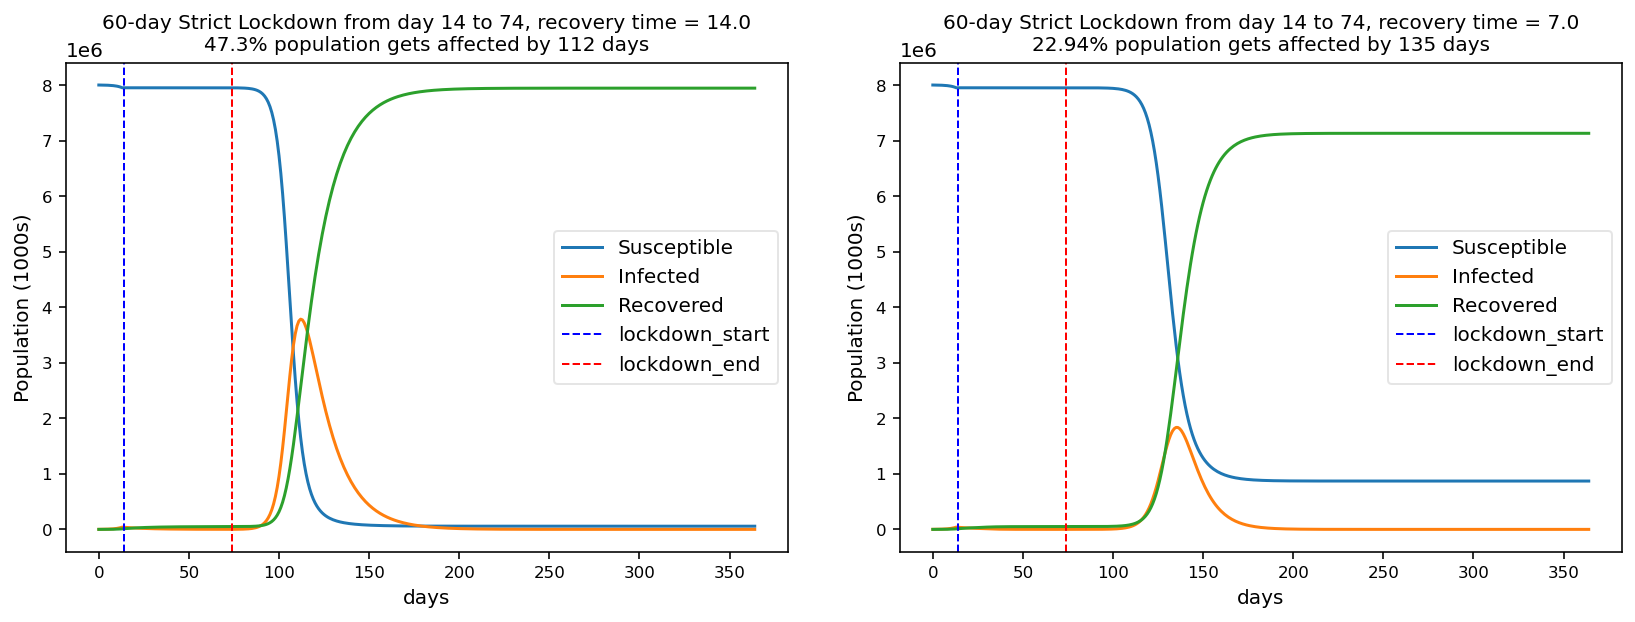

In [30]:
R0 = 5.0
recovery_time = 14.0

lockdowns = [
    {'start':14, 'length':60, 'type':'Strict', 'R0':0.0}
]

improved_recovery_times = [14.0, 7.0]

fig = plt.figure(figsize= (12,5))
for i in range(0,len(improved_recovery_times)):
    lockdown_R0 = lockdowns[0].get('R0')
    lockdown_start = lockdowns[0].get('start')
    lockdown_length = lockdowns[0].get('length')
    lockdown_end = lockdown_start + lockdown_length
    lockdown_type = lockdowns[0].get('type')
 
    S, I, R = sir_model_2(days, N, init_infections, init_recoveries, R0, recovery_time, 
                                 lockdown_R0, lockdown_start, lockdown_end, improved_recovery_times[i])
    
    ax = fig.add_subplot(1,2,i+1)
    ax.plot(S,label='Susceptible')
    ax.plot(I,label='Infected')
    ax.plot(R,label='Recovered')
    ax.set_xlabel('days')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_ylabel('Population (1000s)')
    ax.tick_params(axis='both', labelsize='small')
    ax.axvline(x=lockdown_start, linewidth=1, ls = "--",color='b', label="lockdown_start")
    ax.axvline(x=lockdown_end, linewidth=1, ls = "--",color='r', label="lockdown_end")
    ax.legend(["lockdown start","lockdown end"])
    
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    maxI = np.max(I)/N * 100
    maxIdays = np.argmax(I)
    scenario = '{}-day {} Lockdown from day {} to {}, recovery time = {}'\
    .format(lockdown_length, lockdown_type, lockdown_start, lockdown_end, improved_recovery_times[i])
    pop_affected = '{}% population gets affected by {} days'.format(round(maxI,2), maxIdays)
    ax.set_title('{}\n{}'.format(scenario, pop_affected), fontsize=10)
    
plt.tight_layout(pad=3.0) 


# R0 = 5.0
# recovery_time = 14.0
# improved_recovery_time = 7.0

# lockdowns = [
#     {'start':14, 'length':30, 'type':'Strict', 'R0':0.0},
#     {'start':14, 'length':30, 'type':'Moderate', 'R0':2.0},
#     {'start':14, 'length':60, 'type':'Strict', 'R0':0.0},
#     {'start':14, 'length':60, 'type':'Moderate', 'R0':2.0},
    
#     {'start':21, 'length':30, 'type':'Strict', 'R0':0.0},
#     {'start':21, 'length':30, 'type':'Moderate', 'R0':2.0},
#     {'start':21, 'length':60, 'type':'Strict', 'R0':0.0},
#     {'start':21, 'length':60, 'type':'Moderate', 'R0':2.0},
# ]

# fig = plt.figure(figsize= (20,12))
# for i in range(0,len(lockdowns)):
#     lockdown_R0 = lockdowns[i].get('R0')
#     lockdown_start = lockdowns[i].get('start')
#     lockdown_length = lockdowns[i].get('length')
#     lockdown_end = lockdown_start + lockdown_length
#     lockdown_type = lockdowns[i].get('type')
 
#     S, I, R = sir_model_2(days, N, init_infections, init_recoveries, R0, recovery_time, 
#                                  lockdown_R0, lockdown_start, lockdown_end, improved_recovery_time)
    
# #     ax = fig.add_subplot(3,3,i+1)
#     ax = fig.add_subplot(4,4,i+1)
#     ax.plot(S,label='Susceptible')
#     ax.plot(I,label='Infected')
#     ax.plot(R,label='Recovered')
#     ax.set_xlabel('days')
    
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
#     ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#     ax.set_ylabel('Population (1000s)')
#     ax.tick_params(axis='both', labelsize='small')
#     ax.axvline(x=lockdown_start, linewidth=1, ls = "--",color='b', label="lockdown_start")
#     ax.axvline(x=lockdown_end, linewidth=1, ls = "--",color='r', label="lockdown_end")
#     ax.legend(["lockdown start","lockdown end"])
    
#     legend = ax.legend()
#     legend.get_frame().set_alpha(0.5)
    
#     maxI = np.max(I)/N * 100
#     maxIdays = np.argmax(I)
#     scenario = '{}-day {} Lockdown from day {} to {}, \n R0={}, improved recovery time = {} from day 21'.format(lockdown_length, lockdown_type, lockdown_start, lockdown_end, lockdown_R0, improved_recovery_time)
#     pop_affected = '{}% population gets affected by {} days'.format(round(maxI,2), maxIdays)
#     ax.set_title('{}\n{}'.format(scenario, pop_affected), fontsize=10)
    
# plt.tight_layout(pad=3.0) 

### Its time for vaccine

In [13]:
def f_gamma(t, gamma, improved_gamma, lockdown_start):
    if t >= 21:
        return improved_gamma
    else:
        return gamma

def f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end):
    if t >= lockdown_start and t <= lockdown_end:
        return lockdown_beta
    else:
        return beta

def diff_3(y, t, N, beta, gamma, lockdown_beta, lockdown_start, lockdown_end, improved_gamma, vaccine_start, vaccine_daily_capacity):
    S, I, R = y
    if t >= vaccine_start:
        dSdt = -f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end) * S * I / N - vaccine_daily_capacity
    else:
        dSdt = -f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end) * S * I / N
    
    dIdt = f_beta(t, beta, lockdown_beta, lockdown_start, lockdown_end) * S * I / N - f_gamma(t, gamma, improved_gamma, lockdown_start) * I
    
    if t >= vaccine_start:
        dRdt = f_gamma(t, gamma, improved_gamma, lockdown_start) * I + vaccine_daily_capacity
    else:
        dRdt = f_gamma(t, gamma, improved_gamma, lockdown_start) * I
    
    return dSdt, dIdt, dRdt

def sir_model_3(simulation_length, population_size, init_infections, init_recoveries, reproductive_number, recovery_time, 
                lockdown_reproductive_number, lockdown_start, lockdown_end, improved_recovery_time, 
                vaccine_start, vaccine_daily_capacity):
    daily_reproductive_number = reproductive_number/recovery_time
    daily_recovery_number = 1.0/recovery_time 
    
    lockdown_daily_reproductive_number = lockdown_reproductive_number/recovery_time
    
    improved_recovery_number = 1.0/improved_recovery_time
    
    t = [i for i in range(1,simulation_length+1)]
    
    I0 = init_infections
    S0 = population_size - I0
    R0 = init_recoveries
    
    y0 = S0, I0, R0
    
    ret = odeint(diff_3, y0, t, args=(population_size, daily_reproductive_number, daily_recovery_number, 
                        lockdown_daily_reproductive_number, lockdown_start, lockdown_end, improved_recovery_number,
                        vaccine_start, vaccine_daily_capacity))
    S, I, R = ret.T
    return S, I, R

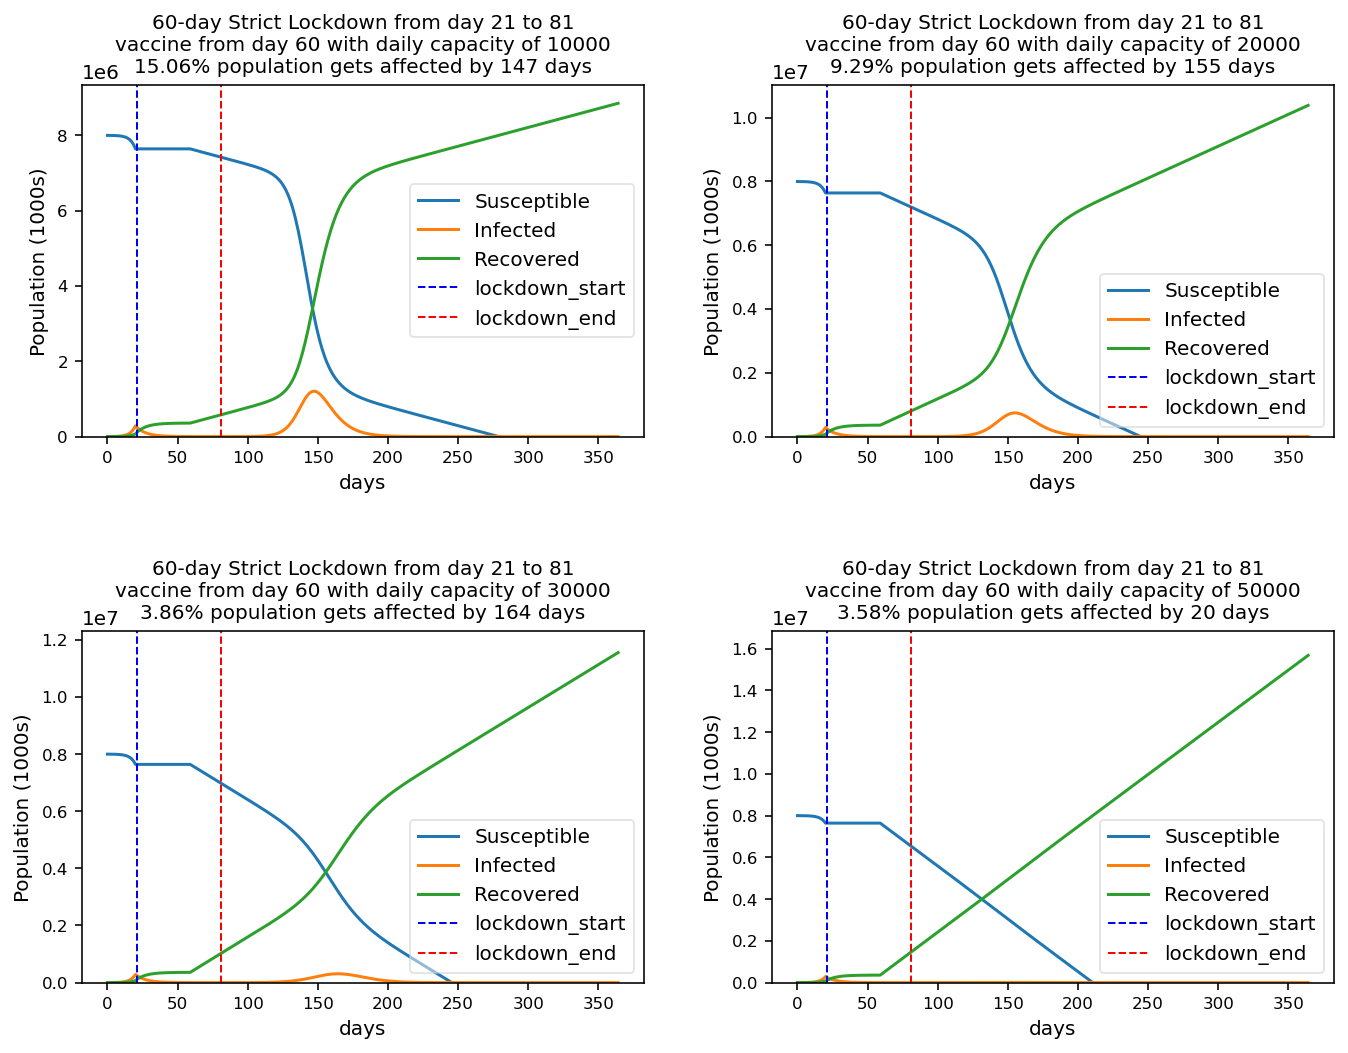

In [14]:
R0 = 5.0
recovery_time = 14.0

lockdowns = [
    {'start':21, 'length':60, 'type':'Strict', 'R0':0.0}
]

improved_recovery_time = 7.0

vaccines = [
    {'start':60, 'capacity':10000},
    {'start':60, 'capacity':20000},
    {'start':60, 'capacity':30000},
    {'start':60, 'capacity':50000}
]

fig = plt.figure(figsize= (10,8))
for i in range(0,len(vaccines)):
    lockdown_R0 = lockdowns[0].get('R0')
    lockdown_start = lockdowns[0].get('start')
    lockdown_length = lockdowns[0].get('length')
    lockdown_end = lockdown_start + lockdown_length
    lockdown_type = lockdowns[0].get('type')
 
    vaccine_start = vaccines[i].get('start')
    vaccine_capacity = vaccines[i].get('capacity')

    S, I, R = sir_model_3(days, N, init_infections, init_recoveries, R0, recovery_time, 
                         lockdown_R0, lockdown_start, lockdown_end, improved_recovery_time, 
                          vaccine_start, vaccine_capacity)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(S,label='Susceptible')
    ax.plot(I,label='Infected')
    ax.plot(R,label='Recovered')
    ax.set_xlabel('days')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_ylabel('Population (1000s)')
    ax.set_ylim(bottom=0.0)
    ax.tick_params(axis='both', labelsize='small')
    ax.axvline(x=lockdown_start, linewidth=1, ls = "--",color='b', label="lockdown_start")
    ax.axvline(x=lockdown_end, linewidth=1, ls = "--",color='r', label="lockdown_end")
    ax.legend(["lockdown start","lockdown end"])
    
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    maxI = np.max(I)/N * 100
    maxIdays = np.argmax(I)
    scenario = '{}-day {} Lockdown from day {} to {}\nvaccine from day {} with daily capacity of {}'\
    .format(lockdown_length, lockdown_type, lockdown_start, lockdown_end, vaccine_start, vaccine_capacity)
    pop_affected = '{}% population gets affected by {} days'.format(round(maxI,2), maxIdays)
    ax.set_title('{}\n{}'.format(scenario, pop_affected), fontsize=10)
    
plt.tight_layout(pad=3.0) 